# Demystifying GPS
A short introduction to GPS technology, and how/why simulate it. 

# Myth or truth?
* Any GPS device can be located by a third-party, as the signal it send to the satellites can be intercepted.

**Myth!** GPS receivers don't need to send data to the satellites to operate. Thus, the GPS device itself cannot be tracked remotely. This was in fact a design requirement for the GPS system!

However, hacking a GPS-equipped smartphone could enable someone to locate this device without its owner to be aware of it ;)

# Myth or truth?
* GPS signal is so weak it has no health effect

**True!** It's around -160dB at ground level.
Comparatively, a GSM device can emit up to 33dB: that's 10^19 times more powerful!

The extreme sensitivity of GPS receivers (1000000 better than GSM for instance) is due to a clever pseudo-random signal correlation that can recover huge transmission error rates.

# Myth or truth?
* GPS is 'encrypted', and changing the encryption key would render all GPS receivers useless

**Partially true** GPS satellites broadcast two signals: a 'regular' and a 'precision' one. Only the latter is really encrypted (and reserved to US military use), but the first one can be 'scrambled' to reduce precision to ~100m

# History

Positionnning systems are an old thing - the first lighthouse guided ships to Alexadrie in ~300bc, and before satellite became a thing, humans used a variety of ground-based radio systems to do stuff like bombing each other's countries accurately (WW II).

The GPS program was started by the US Dept of Defence in 1973, and was fully operational in 1995.

**Fun fact:** *GPS satellites is a proof of the general relativity theory : time goes slower in a strong gravity field, so the clocks in the GPS satellite appears to run faster than the same clock on earth (38µs/day). This had to be compensated for, or it would accumuate ~10km error per day!*

# Positionning principle
* All of the 24 (27) GPS satellite have 4 atomic clock, synced to ~10ps from each other
* Each satellite broadcast its own time, location, trajectory, and some correction information
 * ephemeride, broadcasted every 30s, contains precision information of one satellite (valid ~30 minutes)
 * Almanac, broadcasted every 12.5min, contains coarse information about the whole constellation (valid for couple months)

* Since the time at which a signal was **sent** is known, by measuring the time it's **received** we can evaluate time-of-flight of said signal.
* We use the time-of-flight to estimate the distance between the obeserver and the satellites (d=t.C)

# Trilateration
The position of the observer is the intersection of the circles (spheres), centered on each satellite, of which the diameter is the distance from the observer.

In [1]:
def pltinit():
    plt.figure(figsize=[8,8])
    ax = plt.gca()
    ax.cla()
    ax.set(xlim=(-3, 3), ylim = (-3, 3))
    return ax

In [2]:
import matplotlib.pyplot as plt
import math as m
from random import random

def trilaterate3():
    # Set the figure size as square so we get correct aspect ratio
    ax = pltinit()

    satx = []
    saty = []

    for i in range(3):
        angle = random() * m.pi - m.pi/2
        distance = random() + 1
        x = m.sin(angle)*distance
        y = m.cos(angle)*distance
        satx.append(x)
        saty.append(y)

        circle1 = plt.Circle((x, y), distance, color='r', fill=False)
        ax.add_artist(circle1)
    
    plt.scatter(0, 0, marker='x', c='black')
    plt.scatter(satx, saty, marker='^')

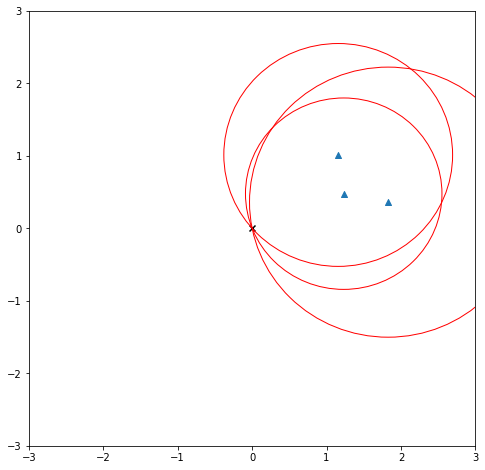

In [3]:
trilaterate3()

# Easy right? Well...
![huston](https://media.giphy.com/media/4Hx5nJBfi8FzFWxztb/giphy.gif "huston")

The receiver's clock is not synchronized with the satellite's clock at startup.  
**therefore, absolute distance from the satellite can't be calculated!**

# Absolute distance is unknown...
But we can tell what's the distance of the satellites **relative to each other**: that's the **pseudoranges**  
*Sat1 is 127.431 km further away than Sat2*

This complexifies the position calculations a little bit: Instead of two points satisfying the distance to 2 satellites (in 2D), we now have a **parabolic curve.** which satisfies d2=d1+d12

In [4]:
# calculate the intersections of two circles
def circle_intersection(circle1, circle2):
    x1,y1,r1 = circle1
    x2,y2,r2 = circle2
    # http://stackoverflow.com/a/3349134/798588
    dx,dy = x2-x1,y2-y1
    d = sqrt(dx*dx+dy*dy)
    if d > r1+r2:
        print("#1")
        return None # no solutions, the circles are separate
    if d < abs(r1-r2):
        print("#2")
        return None # no solutions because one circle is contained within the other
    if d == 0 and r1 == r2:
        print("#3")
        return None # circles are coincident and there are an infinite number of solutions

    a = (r1*r1-r2*r2+d*d)/(2*d)
    h = sqrt(r1*r1-a*a)
    xm = x1 + a*dx/d
    ym = y1 + a*dy/d
    xs1 = xm + h*dy/d
    xs2 = xm - h*dy/d
    ys1 = ym - h*dx/d
    ys2 = ym + h*dx/d

    return (xs1,ys1),(xs2,ys2)

# calculates (x, y) coordinates of possible observer's position, up to max_r1 distance
def intersect_2sat(sat1, sat2, d12, max_r1):
    x1, y1 = sat1
    x2, y2 = sat2
    dx,dy = x2-x1,y2-y1
    d = sqrt(dx*dx+dy*dy) # distance beteen the two satellites
    r1=(d-d12)/2 # initial r1 distance
    r1 = r1 + 0.00001 # add very small value to compensate for the float calculation error
    steps=[r1+sqrt(abs(max_r1 - r1))*i**2/10000 for i in range(100)]
    x, y = [], []
    for r1 in steps:
        i1, i2 = circle_intersection((x1,y1,r1), (x2,y2,r1+d12))
        x.insert(0, i1[0]), y.insert(0, i1[1])
        x.append(i2[0]), y.append(i2[1])
        
    return x, y

def plot_satellite_intersect(sat1, sat2, d12, color='blue'):
    x, y = intersect_2sat(sat1, sat2, d12, 3)
    plt.plot(x, y, color=color)

def calc_d12(sat1, sat2, pos):
    x1, y1 = sat1
    x2, y2 = sat2
    x, y = pos
    return sqrt((x-x2)**2 + (y-y2)**2)-sqrt((x-x1)**2 + (y-y1)**2)

def plot_sat_intersect_from_pos(sat1, sat2, pos, color='blue'):
    plot_satellite_intersect(sat1, sat2, calc_d12(sat1, sat2, pos), color)

def plot_2sat_intersect(max_r1, d12):
    ax = pltinit()
    sats = [sat1, sat2]
    x, y = intersect_2sat(sat1, sat2, d12, max_r1)
    plt.plot(x, y)
    circle1 = plt.Circle(sat1, max_r1, fill=False)
    circle2 = plt.Circle(sat2, max_r1+d12, fill=False)
    
    # Get intersection points
    inter = circle_intersection(sat1 + tuple([max_r1]), sat2 + tuple([max_r1+d12]))
    ix, iy = [i[0] for i in inter], [i[1] for i in inter]
    plt.scatter(ix, iy, marker='x', color='black')

    # plot satellites positions
    satx, saty = [s[0] for s in sats], [s[1] for s in sats]
    plt.scatter(satx, saty, marker='^')
    
    ax.add_artist(circle1)
    ax.add_artist(circle2)

In [5]:
sat1 = (-1,0.5)
sat2 = (1,0.7)
sat3 = (2,0)
sats = [sat1, sat2, sat3]
pos = (0.2,-0.9)

def plot_2d_fix():
    pltinit()
    plot_sat_intersect_from_pos(sat1, sat2, pos)
    plot_sat_intersect_from_pos(sat2, sat3, pos, color='orange')
    plt.scatter([s[0] for s in sats], [s[1] for s in sats], marker='^')
    plt.scatter(pos[0], pos[1], marker='x', c='black')

NameError: name 'sqrt' is not defined

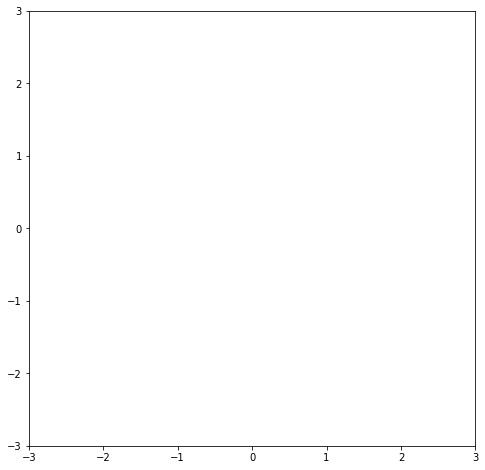

In [6]:
plot_2sat_intersect(0.55, 1)

In [ ]:
plot_2sat_intersect(0.8, 1)

In [ ]:
plot_2sat_intersect(1.4, 1)

# Finding the position
Using 3 (2D fix) of 4 (3D fix) satellites, we can still find one position that satisfies all those distance conditions

In [ ]:
plot_2d_fix()

# Implementation
While in theory using a 'naive' approach using the minimum of 4 satellites can give a valid 3D fix, in practice it is unsufficient in most scenarios, as the resulting precision suffers from various external factors:
* Clock error (like jitter)
* position of the satellites (it's not possible to get a valid fix if some satellites are aligned)
* surrounding constructions or buildings obscuring or reflecting the satellites' signals (multipath)
* EM interferences
* 'local' wheather conditions

In [ ]:
# A small clock error has a little impact if two satellites are well positionned
d12, error = 0, 0.1
pltinit()
plot_satellite_intersect(sat1, sat2, d12)
plot_satellite_intersect(sat1, sat2, d12+error, color='orange')
plot_satellite_intersect(sat1, sat2, d12-error, color='orange')
satx, saty = [s[0] for s in [sat1, sat2]], [s[1] for s in [sat1, sat2]]
plt.scatter(satx, saty, marker='^')
plt.scatter(0.15, -1, marker='X', color='black')

In [ ]:
# The same error has a bigger impact if two satellites are aligned
d12, error = 1.8, 0.1
pltinit()
plot_satellite_intersect(sat1, sat2, d12)
plot_satellite_intersect(sat1, sat2, d12+error, color='orange')
plot_satellite_intersect(sat1, sat2, d12-error, color='orange')
satx, saty = [s[0] for s in [sat1, sat2]], [s[1] for s in [sat1, sat2]]
plt.scatter(satx, saty, marker='^')
plt.scatter(-1.8, -0.38, marker='X', color='black')

# Implementation 'tricks'
Most state-of-the-art GPS receivers implement one or more of the following 'tricks' to get a better precision
* 'smart' satellite selection, to avoid using satellites too close to each other (or aligned)
* successive approximation of the position using all 'locked' satellites + error weighing "à la" Kalman filter
* phased-array antenna to rejet reflexions and jamming signals
* sensor fusion with accelerometer, gyroscope and magnetometer (drones, some cars)

# References
* old bug good reference http://web.gps.caltech.edu/classes/ge111/Docs/GPSbasics.pdf
* Checkout this badass homemade GPS! http://www.aholme.co.uk/GPS/Main.htm
* You can also do your GNSS receiver with an SDR and https://gnss-sdr.org

# GPS simulation
Why?
* Hardware design verification (signal path quality, insertion loss, noise immunity)
* quality test at manufacturing stage 
* GPS receiver performance evaluation/comparison (time-to-fix, precision, multipath rejection)
* GPS receiver Firmware bug hunting (date & time bugs)
* Software testing (even though it's easier to just 'replay' prerecorded NMEA sentences)

# GPS simulation for HW verification
Ideally, you'd want to do a proper radio design, checking line imedance, matchings etc.  
But it requires expensive tools (network analyser) and some information on the RF section of your GPS receiver that might not be easily accessible (NDA).

In that case, an easy way to check the performance of your RF section is to use a GPS simulator (which gives a repeatable signal) and a reference "known good" implementation of your GPS module.  
Using tools like gpsd / gpsmon, you can display the list of 'locked' satellites and their respective **S/N** (signal to noise ratio, in dB). You can also use attenuators to check how low the sensitivity goes before your module can't acquire satellite signal anymore.  
This makes for a relatively low complexity test you can perform with affordable equipment.

# For GPS, 'Y2K' was November 3, 2019
Date is sent as seconds + week number in the GPS data.
Week number being coded on 10 bits, it rolls over every ~19.3 years.  
Indeed, this has to be dealth with if you rely on GPS time!  
In fact, there was some pretty severe issues last year due to that, like cancelled flights or 'bricked' TOM TOMs

Indeed, with a rollover every 20 years, there is no guarantee that the GPS receiver manufacturer has documented how the rollover would happen, now how it's compensated for (there has already one August 21 to August 22, 1999).
And if your GPS receiver is a couple year old, the engineers that wrote its firmware might not be in the same company anymore, so no one know how it works.
But no worries, let's check the source code and find for ourselves how rollover is managed!

Just kidding, indeed the source code is closed!
You really fell for this?

# Testing rollover was the last recourse
As we had an answer from the manufacturer of the specific GPS module we were using **days before the rollover**, we had to test for ourself. And indeed, we saw that our GPS receiver did rolled back to 1999. We weren't really surprised.  
The thing we did not forsee was that, 4 month later, on **some** devices the GPS time went from 23:59:59 31/12/99 to... 00:00:00 01/01/**-1**  
(and I won't even talk about leap second compensation, or lack thereof)

![y2k](y2k19.jpg) 

# Simulation tools: professionnal tools
Generally expensive, but possibilities are endles (some enable simulating multipath, ionosphere effects, jatter etc). Spectracom GSG-5 is one of these tools. Too expensive to buy (10-30k€) unless you are designing GPS modules for a living, so we rented it (~500€ for 2 months).
![spectracom](Spectracom_GSG-5.jpg)

# Simulation tools: the 'hacker' way
Use a Software Defined Radio with a precise clock reference (150-600€) + attenuator  
[gpssim](https://github.com/osqzss/gps-sdr-sim) (FOSS) can be used to generate the 'stream' that the SDR has to send.

But there are some 'gotchas':
* most SDR have a shitty clock reference (20ppm). As a result, your GPS receiver will have trouble 'locking' on the simulated GPS signal, and migt not get a fix at all. It's better with an 0.5ppm clock reference but still not perfect.
* RF output power is... hard to estimate. You'll have to buy a couple different attenuators to get the right output power.
* gpssim is quite CPU-intensive (forget running this on an rPI). You can save the 'raw' stream to disk though (~>1GB/min)

# DEMO!